## For a given "lake" boundary contour, 
### we will want to composite gridded quantities by distance from that boundary contour. 
## Do it with `groupby` operation on a distance field
##### Computed and written out 

Shapely [object.buffer](https://shapely.readthedocs.io/en/stable/manual.html#spatial-analysis-methods) measures these buffer distances, negative values being outside the shape and positive values inside.  

[rioxarray](https://corteva.github.io/rioxarray/stable/examples/examples.html) can clip data to a polynomial or buffer 

Shapely/geopandas has a `distance` method 

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import geopandas as gp

## grab a case in 2014-2018 
#### lakes dataframe was "improved" in LakeCaseStudy.ipynb
by adding more columns: firstt, dur_days, yyyy, mm, coastlat for screening purposes

In [4]:
df = pd.read_csv('ccvls_stats_2014-2018.improved.csv')
# df

In [5]:
equatorcases = df[ abs(df.coastlat) < 10 ] # 162 of them exceeding 1 day 
eq7cases = equatorcases[ equatorcases.dur_days > 6 ]

# Pick a clean one: all polygon, no holes (multipolygons)
case = eq7cases.iloc[5]
case
# showme(case.filename) see LakeCaseStudy.ipynb for showme function

Unnamed: 0.1                                853
Unnamed: 0                                  863
lasttime                    2017-05-28 11:00:00
duration                        7 days 04:00:00
areatime                            5690.601728
tqv_values                                 55.0
maxarea                               50.852737
filename        2017_05_28_11_lat5p291S.geojson
ymdh                              2017_05_28_11
firsttime                   2017-05-21 07:00:00
dur_days                                      7
yyyy                                       2017
mm                                            5
coastlat                                 -5.291
Name: 853, dtype: object

In [210]:
filename = case.filename
gdf = gp.read_file('GEOJSONS/'+filename)
gdf
# to avoid area warnings, use an equal-area map projection (CRS)
# https://gis.stackexchange.com/questions/372564/userwarning-when-trying-to-get-centroid-from-a-polygon-geopandas
gdf_area = gdf.set_crs(epsg = "4326", inplace = True)         #.to_crs('+proj=cea')

<AxesSubplot:>

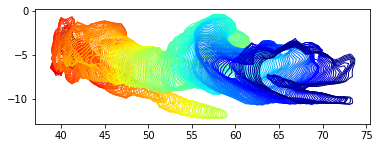

In [211]:
gdf.plot(column='time', facecolor='none', cmap='jet') #, alpha=1) #, legend=True)

/var/folders/v9/8pr92c8s0m14426rc7jfm2c80000gn/T/ipykernel_96932/634526862.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_area.centroid.to_crs(gdf.crs).plot(ax=ax,color='black')
/Users/brianmapes/opt/miniconda3/envs/geopy/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'polygons w/no holes? lasting 7 days, one merger')

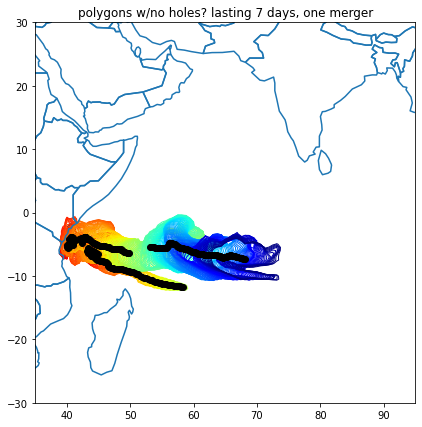

In [212]:
# with map context and centroids 
fig, ax = plt.subplots(figsize=[8,7])
ax.set_aspect('equal')
ax.set_xlim(35, 95)
ax.set_ylim(-30,30)

gdf.plot(ax=ax, column='time', facecolor='none', \
                cmap='jet', alpha=1) #, legend=True)

# Plot centroids 
gdf_area.centroid.to_crs(gdf.crs).plot(ax=ax,color='black')

#gdf.boundary.plot(ax=ax, color='black')
path = gp.datasets.get_path('naturalearth_lowres') # Geography background
mapdf = gp.read_file(path)
mapdf.boundary.plot(ax=ax)
    
ax.set_title('polygons w/no holes? lasting 7 days, one merger')

/var/folders/v9/8pr92c8s0m14426rc7jfm2c80000gn/T/ipykernel_96932/3246302327.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  plt.plot(gdf.time, gdf_area.area)


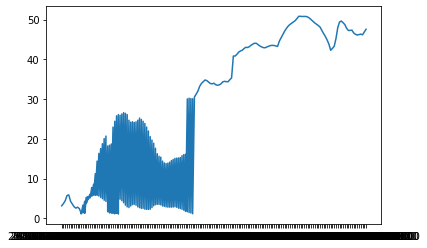

In [213]:
plt.plot(gdf.time, gdf_area.area)

/var/folders/v9/8pr92c8s0m14426rc7jfm2c80000gn/T/ipykernel_96932/2264692458.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.iloc[ gdf_area.area.argmax() ].geometry


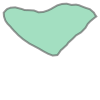

In [215]:
# shape of largest blob at any time 

gdf.iloc[ gdf_area.area.argmax() ].geometry

# Learn about boundary, buffer, centroid

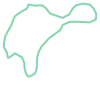

In [11]:
# 50th polygon is distinctive shape 
blob = gdf.iloc[ 50 ]
blob.geometry.boundary

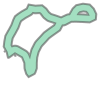

In [48]:
# Buffer is the region just inside the boundary 
blobuf = blob.geometry.boundary.buffer(.7, single_sided=True) # units are degrees
blobuf

In [13]:
# We will want to further subdivide by angle from a centroid to compute propagation direction 
centroidlon = blob.geometry.centroid.bounds[0]
centroidlat = blob.geometry.centroid.bounds[1]

centroidlon, centroidlat

(42.25679859114371, -4.090041136659944)

# Try rioxarray `clip` method 

In [14]:
import rioxarray as rxr

In [227]:
# MERRA: get oneself authenticated first 
#testURL = 'https://goldsmr5.gesdisc.eosdis.nasa.gov/dods/M2I3NPASM'
#testURL = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds084.1/2021/20210719/gfs.0p25.2021071900.f024.grib2'

# 2D fields vertical integrals 
URL = 'dods://goldsmr4.gesdisc.eosdis.nasa.gov/dods/M2I1NXASM'
ds = xr.open_dataset(URL, decode_coords='all').sel(time=slice(case.firsttime,case.lasttime), \
                                                   lat=slice(-30,30),lon=slice(35,95))

# Convert to rioxarray dataset, with x,y set to lon,lat and a standard CRS defined
dsr = ds.rio.set_spatial_dims('lon','lat',inplace=True)
dsr.rio.write_crs("epsg:4326", inplace=True)
dsr

/Users/brianmapes/opt/miniconda3/envs/geopy/lib/python3.10/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


<xarray.Dataset>
Dimensions:      (time: 172, lat: 121, lon: 97)
Coordinates:
  * time         (time) datetime64[ns] 2017-05-21T08:00:00.000003 ... 2017-05...
  * lat          (lat) float64 -30.0 -29.5 -29.0 -28.5 ... 28.5 29.0 29.5 30.0
  * lon          (lon) float64 35.0 35.62 36.25 36.88 ... 93.12 93.75 94.38 95.0
    spatial_ref  int64 0
Data variables: (12/24)
    disph        (time, lat, lon) float32 ...
    ps           (time, lat, lon) float32 ...
    qv10m        (time, lat, lon) float32 ...
    qv2m         (time, lat, lon) float32 ...
    slp          (time, lat, lon) float32 ...
    t10m         (time, lat, lon) float32 ...
    ...           ...
    u10m         (time, lat, lon) float32 ...
    u2m          (time, lat, lon) float32 ...
    u50m         (time, lat, lon) float32 ...
    v10m         (time, lat, lon) float32 ...
    v2m          (time, lat, lon) float32 ...
    v50m         (time, lat, lon) float32 ...
Attributes:
    title:        MERRA-2 inst1_2d_asm_Nx: 2d,1-Hourly,Instantaneous,Single-L...
    Conventions:  COARDS\nGrADS
    dataType:     Grid
    history:      Thu Jan 19 02:15:29 GMT 2023 : imported by GrADS Data Serve...

In [228]:
blob.time

'2017-05-27T06:00:00'

In [122]:
# Select the time of the blob 
dsrb = dsr.sel(time=blob.time).rio.set_spatial_dims('lon','lat',inplace=True)
dsrb

<xarray.Dataset>
Dimensions:      (time: 1, lat: 101, lon: 113)
Coordinates:
  * time         (time) datetime64[ns] 2017-05-27T06:00:00
  * lat          (lat) float64 -25.0 -24.5 -24.0 -23.5 ... 23.5 24.0 24.5 25.0
  * lon          (lon) float64 30.0 30.62 31.25 31.88 ... 98.75 99.38 100.0
    spatial_ref  int64 0
Data variables: (12/24)
    disph        (time, lat, lon) float32 0.3308 9.457 7.119 ... 2.465 4.119
    ps           (time, lat, lon) float32 8.702e+04 8.712e+04 ... 8.073e+04
    qv10m        (time, lat, lon) float32 0.005655 0.005672 ... 0.01127 0.01074
    qv2m         (time, lat, lon) float32 0.007309 0.007129 ... 0.01175 0.01109
    slp          (time, lat, lon) float32 1.013e+05 1.013e+05 ... 1.005e+05
    t10m         (time, lat, lon) float32 287.6 287.4 289.6 ... 295.4 295.6
    ...           ...
    u10m         (time, lat, lon) float32 ...
    u2m          (time, lat, lon) float32 ...
    u50m         (time, lat, lon) float32 ...
    v10m         (time, lat, lon) float32 ...
    v2m          (time, lat, lon) float32 ...
    v50m         (time, lat, lon) float32 ...
Attributes:
    title:        MERRA-2 inst1_2d_asm_Nx: 2d,1-Hourly,Instantaneous,Single-L...
    Conventions:  COARDS\nGrADS
    dataType:     Grid
    history:      Thu Jan 19 02:15:29 GMT 2023 : imported by GrADS Data Serve...

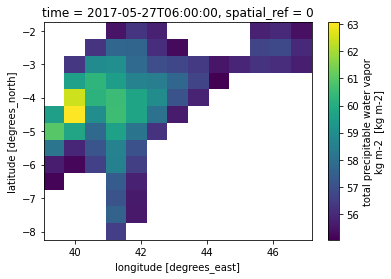

In [17]:
# CLIP 

dsrblob = dsrb.rio.clip( [blob.geometry], crs=4326 ) #TypeError: 'Polygon' object is not iterable SO PUT IT IN BRACKETS []
# All values above 55mm as expected! 
dsrblob.tqv.plot()

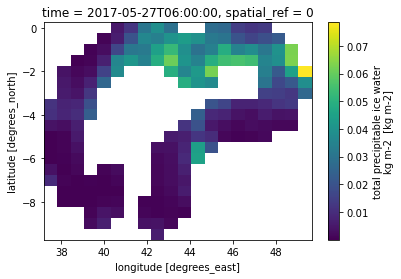

In [18]:
blobuf = blob.geometry.boundary.buffer(-2, single_sided=True) # negative values are outside the blob 

dsrblobuf = dsrb.rio.clip( [blobuf], crs=4326 ) #TypeError: 'Polygon' object is not iterable SO PUT IT IN BRACKETS []
dsrblobuf.tqi.plot()

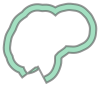

In [19]:
# Subtract shapes to get a buffer from 1-3 degrees beyond the blob 
blobuf31 = blob.geometry.boundary.buffer(-3, single_sided=True)-blobuf 
blobuf31

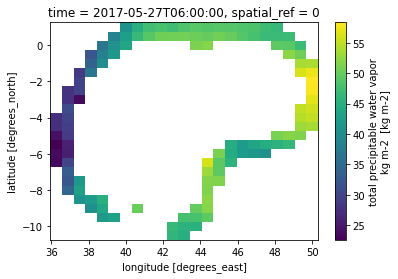

In [20]:
dsrblobuf31 = dsrb.rio.clip( [blobuf31], crs=4326 ) 
dsrblobuf31.tqv.plot()

In [21]:
# All the fields in the 1-3 degree outer buffer of the blob! 
dsrblobuf31.mean()

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int64 0
Data variables: (12/24)
    disph        float32 1.133
    ps           float32 9.838e+04
    qv10m        float32 0.01652
    qv2m         float32 0.01693
    slp          float32 1.014e+05
    t10m         float32 299.0
    ...           ...
    u10m         float32 -2.089
    u2m          float32 -1.776
    u50m         float32 -2.394
    v10m         float32 4.123
    v2m          float32 3.266
    v50m         float32 4.797

# Construct distance-from-boundary fields instead

In [198]:
# For blob time (dsrb), repurpose the disph variable as a container, renaming it 

result = dsrb.rename({"disph":"distance"}).distance.squeeze()
result

<xarray.DataArray 'distance' (lat: 101, lon: 113)>
array([[ 0.330811,  9.457031,  7.119141, ...,  0.      ,  0.      ,  0.      ],
       [ 0.310303,  0.715332,  2.089844, ...,  0.      ,  0.      ,  0.      ],
       [ 7.177734,  0.333618,  0.273193, ...,  0.      ,  0.      ,  0.      ],
       ...,
       [ 0.053589,  0.053162,  0.05629 , ..., 16.382812,  6.154297,  4.927734],
       [ 0.054718,  0.054535,  0.057541, ..., 14.957031,  4.068359,  5.041016],
       [ 0.054733,  0.054703,  0.060394, ...,  5.662109,  2.464844,  4.119141]],
      dtype=float32)
Coordinates:
    time         datetime64[ns] 2017-05-27T06:00:00
  * lat          (lat) float64 -25.0 -24.5 -24.0 -23.5 ... 23.5 24.0 24.5 25.0
  * lon          (lon) float64 30.0 30.62 31.25 31.88 ... 98.75 99.38 100.0
    spatial_ref  int64 0
Attributes:
    units:      m
    long_name:  zero plane displacement height m

In [134]:
from shapely.geometry import Polygon, LineString, Point

In [144]:
lat2d = dsr.lat.values[:,None]   + dsr.lon.values*0
lon2d = dsr.lat.values[:,None]*0 + dsr.lon.values
points = gp.GeoSeries( [Point(x, y) for x, y in zip(lon2d.ravel(),lat2d.ravel()) ] )

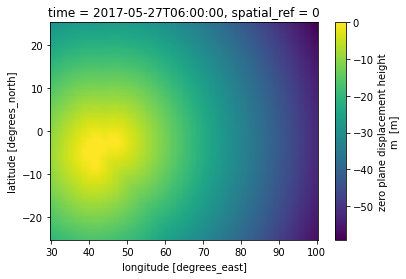

In [202]:
# Compute array of distances from  blob, put them in result xarray DataArray

dist = points.distance(blob.geometry).values.reshape(len(dsr.lat),len(dsr.lon))
isin = points.within(blob.geometry).values.reshape(len(dsr.lat),len(dsr.lon))
dist *= 2*(isin-0.5)  # signed distance from boundary, positive is interior 

result.values = dist
result.plot()

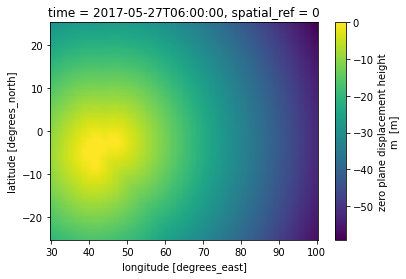

0        POINT (30.00000 -25.00000)
1        POINT (30.62500 -25.00000)
2        POINT (31.25000 -25.00000)
3        POINT (31.87500 -25.00000)
4        POINT (32.50000 -25.00000)
                    ...            
11408     POINT (97.50000 25.00000)
11409     POINT (98.12500 25.00000)
11410     POINT (98.75000 25.00000)
11411     POINT (99.37500 25.00000)
11412    POINT (100.00000 25.00000)
Length: 11413, dtype: geometry

In [209]:
points.set_crs(epsg = "4326", inplace = True)

0        POINT (30.00000 -25.00000)
1        POINT (30.62500 -25.00000)
2        POINT (31.25000 -25.00000)
3        POINT (31.87500 -25.00000)
4        POINT (32.50000 -25.00000)
                    ...            
11408     POINT (97.50000 25.00000)
11409     POINT (98.12500 25.00000)
11410     POINT (98.75000 25.00000)
11411     POINT (99.37500 25.00000)
11412    POINT (100.00000 25.00000)
Length: 11413, dtype: geometry

In [225]:
distall = points.distance(gdf_area.geometry[100])

/var/folders/v9/8pr92c8s0m14426rc7jfm2c80000gn/T/ipykernel_96932/3631138782.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distall = points.distance(gdf_area.geometry[100])


In [226]:
distall?

Type:        Series
String form:
0        22.949765
           1        22.562058
           2        22.163098
           3        21.767574
           4        21.382797
           <...>  57.316684
           11410    57.856646
           11411    58.398304
           11412    58.941612
           Length: 11413, dtype: float64
Length:      11413
File:        ~/opt/miniconda3/envs/geopy/lib/python3.10/site-packages/pandas/core/series.py
Docstring:  
One-dimensional ndarray with axis labels (including time series).

Labels need not be unique but must be a hashable type. The object
supports both integer- and label-based indexing and provides a host of
methods for performing operations involving the index. Statistical
methods from ndarray have been overridden to automatically exclude
missing data (currently represented as NaN).

Operations between Series (+, -, /, \*, \*\*) align values based on their
associated index values-- they need not be the same length. The result
index will be th

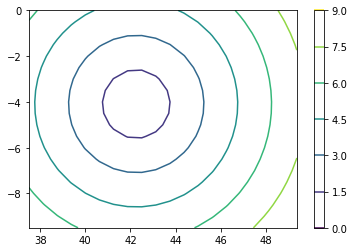

In [22]:
lat = dsrblobuf.lat.data
lon = dsrblobuf.lon.data

distance = np.sqrt((lat - centroidlat)[:,None]**2 + ((lon - centroidlon)**2))
plt.contour(lon, lat, distance); plt.colorbar()

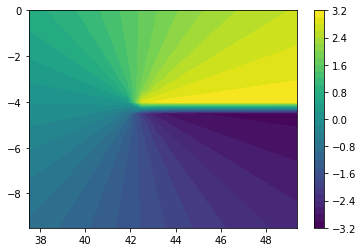

In [39]:
angle = np.arctan2((lat - centroidlat)[:,None], -(lon - centroidlon))
plt.contourf(lon, lat, angle, 32); plt.colorbar()

MissingDimensionsError: cannot set variable 'distance' with 2-dimensional data without explicit dimension names. Pass a tuple of (dims, data) instead.